In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import PIL.ImageOps as ImageOps
import PIL.Image as Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
class_names = ['Arive-Dantu',
               'Basale',
               'Curry']

In [6]:
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

In [7]:
IMAGE_SIZE = (400, 400)

In [8]:
def pre_process(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    return image

In [9]:
def load_data():
    datasets = ['/content/drive/My Drive/ColabNotebooks/practice']
    output = []

    # Iterate through the dataset
    for dataset in datasets:
        images = []
        labels = []

        print(f"Loading {dataset}")

        # Iterate through each folder representing a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in the folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(dataset, folder, file)
                image = pre_process(img_path)
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))

    if len(output) == 1:
        images, labels = output[0]

        # Split the dataset randomly
        train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
        output.append((train_images, train_labels, test_images, test_labels))

        return output

In [10]:
train_images, train_labels, test_images, test_labels = load_data()[1]

Loading /content/drive/My Drive/ColabNotebooks/practice


100%|██████████| 500/500 [00:07<00:00, 63.57it/s]


In [11]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [12]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1200
Number of testing examples: 300
Each image is of size: (400, 400)


In [13]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [14]:
def display_examples(class_names, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [15]:
def display_random_image(class_names, images, labels):

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

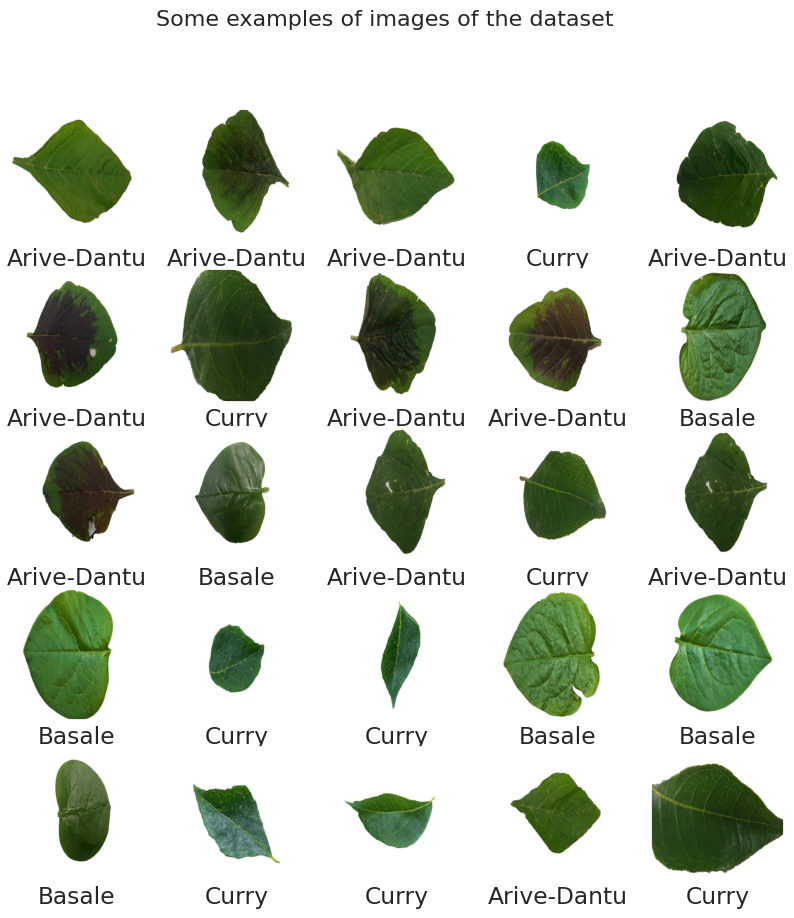

In [16]:
display_examples(class_names, train_images, train_labels)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 200 * 200, nb_classes)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_images_tensor = torch.tensor(train_images.transpose((0, 3, 1, 2)))
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images.transpose((0, 3, 1, 2)))
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [19]:
for epoch in range(5):
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{5}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0045
Epoch [2/5], Loss: 0.0576
Epoch [3/5], Loss: 0.0686
Epoch [4/5], Loss: 0.0018
Epoch [5/5], Loss: 0.0004


In [20]:
torch.save(model.state_dict(), 'model.pth')

print('Model saved successfully!')

Model saved successfully!


In [21]:
model.load_state_dict(torch.load('model.pth'))
print('Model loaded successfully!')

def make_predictions(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, _ in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.tolist())
    return predictions

test_loader = DataLoader(TensorDataset(test_images_tensor, test_labels_tensor), batch_size=32, shuffle=False)
predictions = make_predictions(model, test_loader)

for i in range(5):
    print(f'Image {i}: Predicted class - {class_names[predictions[i]]}')


Model loaded successfully!
Image 0: Predicted class - Curry
Image 1: Predicted class - Curry
Image 2: Predicted class - Basale
Image 3: Predicted class - Basale
Image 4: Predicted class - Basale


Accuracy: 0.9700


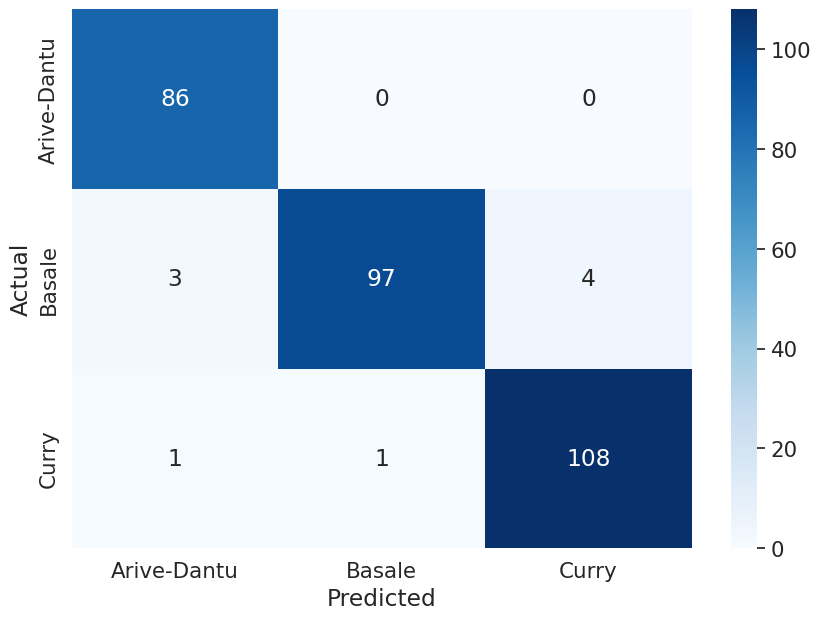

In [25]:
actual_labels = test_labels
predicted_labels = make_predictions(model, test_loader)

accuracy = np.sum(actual_labels == predicted_labels) / len(actual_labels)
print(f"Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

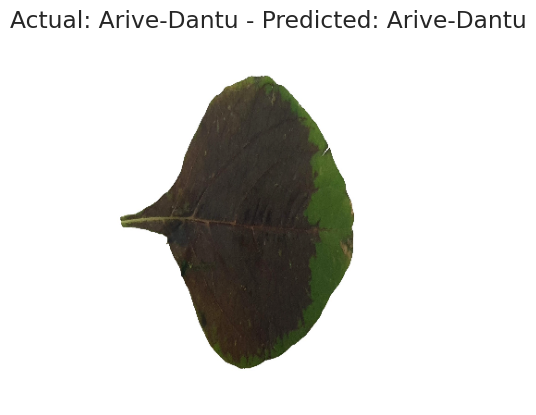

In [27]:
#the actual and predicted image at index 10
plt.figure()
plt.imshow(test_images[10])
plt.xticks([])
plt.yticks([])
plt.grid(False)
actual_label = class_names[actual_labels[10]]
predicted_label = class_names[predicted_labels[10]]
plt.title(f'Actual: {actual_label} - Predicted: {predicted_label}')
plt.show()

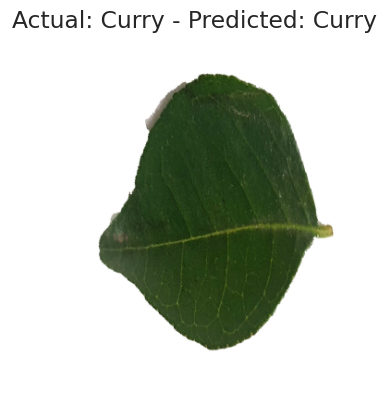

In [29]:
# Display the actual and predicted image at index 220
plt.figure()
plt.imshow(test_images[220])
plt.xticks([])
plt.yticks([])
plt.grid(False)
actual_label = class_names[actual_labels[220]]
predicted_label = class_names[predicted_labels[220]]
plt.title(f'Actual: {actual_label} - Predicted: {predicted_label}')
plt.show()